In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import csv
from numpy import genfromtxt
from scipy.spatial import distance
import os
import glob
from pylab import *
from matplotlib.pyplot import imread
import networkx as nx

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader, InMemoryDataset, Data, download_url, extract_zip
from torch_geometric.utils.convert import to_networkx

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
def construct_M(height_pixels, width_pixels):
    fov_x = pi/3.0
    fov_y = 2.0 * arctan(height_pixels * tan(fov_x/2.0) / width_pixels)
    near  = 1.0
    far   = 1000.0

    f_h    = tan(fov_y/2.0)*near
    f_w    = f_h*width_pixels/height_pixels
    left   = -f_w
    right  = f_w
    bottom = -f_h
    top    = f_h

    M_proj      = matrix(zeros((4,4)))
    M_proj[0,0] = (2.0*near)/(right - left)
    M_proj[1,1] = (2.0*near)/(top - bottom)
    M_proj[0,2] = (right + left)/(right - left)
    M_proj[1,2] = (top + bottom)/(top - bottom)
    M_proj[2,2] = -(far + near)/(far - near)
    M_proj[3,2] = -1.0
    M_proj[2,3] = -(2.0*far*near)/(far - near)
    
    return M_proj

In [4]:
def world2screen_proj(p_world, camera_pos, camera_rot, height_pixels, width_pixels):
    R_cam2world = matrix(camera_rot)
    t_cam2world = matrix(camera_pos).T
    R_world2cam = R_cam2world.T
    t_world2cam = -R_world2cam*t_cam2world

    M = construct_M(height_pixels, width_pixels)

    p_cam      = t_world2cam + R_world2cam*p_world
    p_cam_     = matrix(r_[ p_cam.A1, 1 ]).T
    p_clip     = M * p_cam_
    p_ndc      = p_clip/p_clip[3]
    p_ndc_     = p_ndc.A1
    p_screen_x = 0.5*(p_ndc_[0]+1)*(width_pixels-1)
    p_screen_y = (1 - 0.5*(p_ndc_[1]+1))*(height_pixels-1)
    p_screen_z = (p_ndc_[2]+1)/2.0
    p_screen   = matrix([p_screen_x, p_screen_y, p_screen_z]).T
    
    return p_screen

In [5]:
def assign_labels(mesh_objects_sii, mesh_objects_si, metadata_objects, nyu_labels, bb_pos):
    bb_labels = []
    bb_error = []
    n_bb = bb_pos.shape[0] - 1
    # nyu_id = np.zeros(n_bb)

    for i in range(n_bb):
        lowlvl_instances_in_current_bb = np.where(mesh_objects_sii == i+1)[0]
        if lowlvl_instances_in_current_bb.size > 0:
            nyu_id = mesh_objects_si[lowlvl_instances_in_current_bb[0]]
            # bb_labels.append(nyu_labels[int(nyu_id[i])][1])
            bb_labels.append(nyu_id)
        else:
           bb_error.append(i+1)
           bb_labels.append(np.array([-1], dtype=int64)) # TODO: consider another solution to this problem (eg. remove BB that are 'invalid')
    
    return bb_labels, bb_error

In [6]:
def calculate_distance(threshold, a2m, bb_pos, bb_error):
    n_bb = bb_pos.shape[0] - 1
    bb_pos_m = bb_pos*a2m

    distances = np.zeros((n_bb, n_bb))
    distances[:, :] = np.nan

    for i in range(n_bb):
        for j in range(n_bb):
            if i+1 not in bb_error and j+1 not in bb_error:
                distances[i, j] = distance.euclidean(bb_pos_m[i+1, :], bb_pos_m[j+1, :])

    distance_mask = (distances <= threshold)*int(1) # True for objects that are within [threshold] m of other objects
    np.fill_diagonal(distance_mask, 0)
    
    return distance_mask

In [7]:
def construct_adjacency_matrix(n_bb, bb_in_sample, distance_mask):    
    # Array of BB to ignore in the adjacency matrix (not present in the graph)
    temp = arange(1, n_bb+1) # goes from 1 to 55
    bb_not_in_sample = np.delete(temp, bb_in_sample - np.ones(len(bb_in_sample), dtype=int))
    index = bb_not_in_sample - np.ones(len(bb_not_in_sample), dtype=int)
    
    adjacency_matrix = copy(distance_mask)
    adjacency_matrix[index,:] = np.zeros((len(bb_not_in_sample), n_bb))
    adjacency_matrix[:, index] = np.zeros((n_bb, len(bb_not_in_sample)))
    return adjacency_matrix

In [8]:
def plot_scene(n_bb, bb_pos, bb_in_sample, camera_pos, camera_rot, height_pixels, width_pixels, adjacency_matrix, bb_labels, tonemap):

    # Attribute label to each graph node from the constructed labels for the scene
    temp = arange(1, n_bb+1)
    bb_not_in_sample = np.delete(temp, bb_in_sample - np.ones(len(bb_in_sample), dtype=int))
    bb_in_sample_nodes = np.delete(temp, bb_not_in_sample - np.ones(len(bb_not_in_sample), dtype=int))
    node_labels_dict = {}
    for i in bb_in_sample_nodes:
        node_labels_dict[i] = bb_labels[i-1]

    # Calculate 2-D postions of BB centres (for graphing)
    bb_pos_nodes = {}
    for i in bb_in_sample:
        bb_pos_ = expand_dims(bb_pos[i], 1) # homogenous coordinates
        bb_pos_nodes_screen = world2screen_proj(bb_pos_, camera_pos, camera_rot, height_pixels, width_pixels)

        x = np.ravel(bb_pos_nodes_screen[0])
        x = x.astype(int)
        x = x.item()
        x = np.clip(x, 0, width_pixels)

        y = np.ravel(bb_pos_nodes_screen[1])
        y = y.astype(int)
        y = y.item()
        y = - y + height_pixels
        y = np.clip(y, 0, height_pixels)

        bb_pos_nodes[i] = (x, y)
    
    # Define graph
    rows, cols = np.where(adjacency_matrix == 1)
    rows = rows + 1
    cols = cols + 1
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()

    gr.add_nodes_from(bb_in_sample)
    gr.add_edges_from(edges)

    y_lim, x_lim = tonemap.shape[:-1]
    extent = 0, x_lim, 0, y_lim

    fig = plt.figure(figsize=(10,10))
    plt.imshow(tonemap, extent=extent, interpolation='nearest')
    nx.draw(gr, pos=bb_pos_nodes, node_size=50, with_labels=True, labels=node_labels_dict, font_size=10)
    plt.show()

    return None

In [9]:
def import_scene(scene_name, scene_dir):
    detail_dir = os.path.join(scene_dir, "_detail")

    bb_size_dir = os.path.join(detail_dir, "mesh", "metadata_semantic_instance_bounding_box_object_aligned_2d_extents.hdf5")
    bb_pos_dir = os.path.join(detail_dir, "mesh", "metadata_semantic_instance_bounding_box_object_aligned_2d_positions.hdf5")
    bb_rot_dir = os.path.join(detail_dir, "mesh", "metadata_semantic_instance_bounding_box_object_aligned_2d_orientations.hdf5")

    mesh_objects_si_dir = os.path.join("evermotion_dataset", "scenes", scene_name, "_detail", "mesh", "mesh_objects_si.hdf5")
    mesh_objects_sii_dir = os.path.join("evermotion_dataset", "scenes", scene_name, "_detail", "mesh", "mesh_objects_sii.hdf5")
    metadata_objects_dir = os.path.join("evermotion_dataset", "scenes", scene_name, "_detail", "mesh", "metadata_objects.csv")
    a2m_dir = os.path.join(detail_dir, "metadata_scene.csv")

    with h5py.File(bb_size_dir, "r") as f: bb_sizes = f['dataset'][:]
    with h5py.File(bb_rot_dir, "r") as f: bb_rot = f['dataset'][:]
    with h5py.File(bb_pos_dir, "r") as f: bb_pos = f['dataset'][:]

    with h5py.File(mesh_objects_si_dir, "r") as f: mesh_objects_si = f['dataset'][:]
    with h5py.File(mesh_objects_sii_dir, "r") as f: mesh_objects_sii = f['dataset'][:]
    metadata_objects = genfromtxt(metadata_objects_dir, delimiter=None, dtype=str)

    with open(a2m_dir, newline='') as csvfile:
        metadata_scene = list(csv.reader(csvfile))
        a2m = float(metadata_scene[1][1])
    
    return bb_sizes, bb_rot, bb_pos, mesh_objects_si, mesh_objects_sii, metadata_objects, a2m

In [10]:
def import_dataset_labels():
    nyu_labels_dir = os.path.join("code", "cpp", "tools", "scene_annotation_tool", "semantic_label_descs.csv")
    nyu_labels = genfromtxt(nyu_labels_dir, delimiter=',', dtype=None, encoding=None, autostrip=True)

    scene_labels_dir = os.path.join("evermotion_dataset", "analysis", "metadata_camera_trajectories.csv")
    scene_labels = genfromtxt(scene_labels_dir, delimiter=',', dtype=None, encoding=None, autostrip=True)[1:,[0,7,8]]
    return nyu_labels, scene_labels

In [11]:
def import_camera(scene_dir, camera_name):
    detail_dir = os.path.join(scene_dir, "_detail")
    camera_pos_dir = os.path.join(detail_dir, camera_name, "camera_keyframe_positions.hdf5")
    camera_rot_dir = os.path.join(detail_dir, camera_name, "camera_keyframe_orientations.hdf5")
    with h5py.File(camera_pos_dir, "r") as f: camera_pos_all = f['dataset'][:]
    with h5py.File(camera_rot_dir, "r") as f: camera_rot_all = f['dataset'][:]
    return camera_pos_all, camera_rot_all

In [12]:
def import_frame(tonemap_dir, segmentation_dir):
    tonemap = imread(tonemap_dir)
    with h5py.File(segmentation_dir, "r") as f: segmentation = f['dataset'][:]
    return tonemap, segmentation

In [14]:
hf = h5py.File('data.h5', 'a')
hf.create_dataset('data', data=orig_data, compression="gzip", chunks=True, maxshape=(None,))

0 : loaded frame.0000.tonemap.jpg and frame.0000.semantic_instance.hdf5
Data(x=[32, 1], edge_index=[2, 534], y=[1])


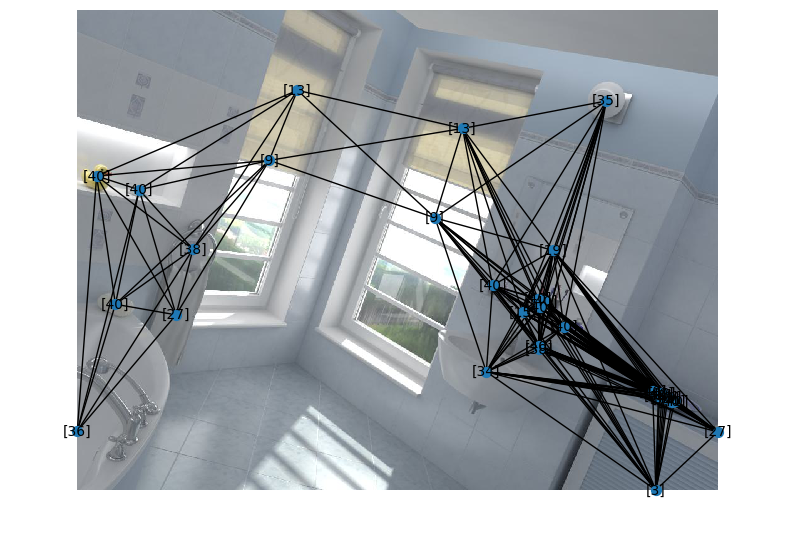

1 : loaded frame.0001.tonemap.jpg and frame.0001.semantic_instance.hdf5
Data(x=[23, 1], edge_index=[2, 240], y=[1])


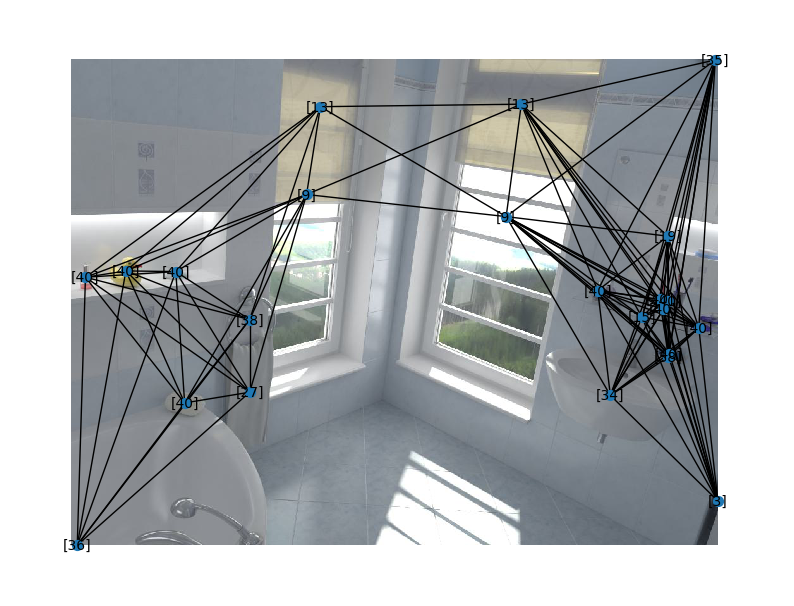

2 : loaded frame.0002.tonemap.jpg and frame.0002.semantic_instance.hdf5
Data(x=[5, 1], edge_index=[2, 16], y=[1])


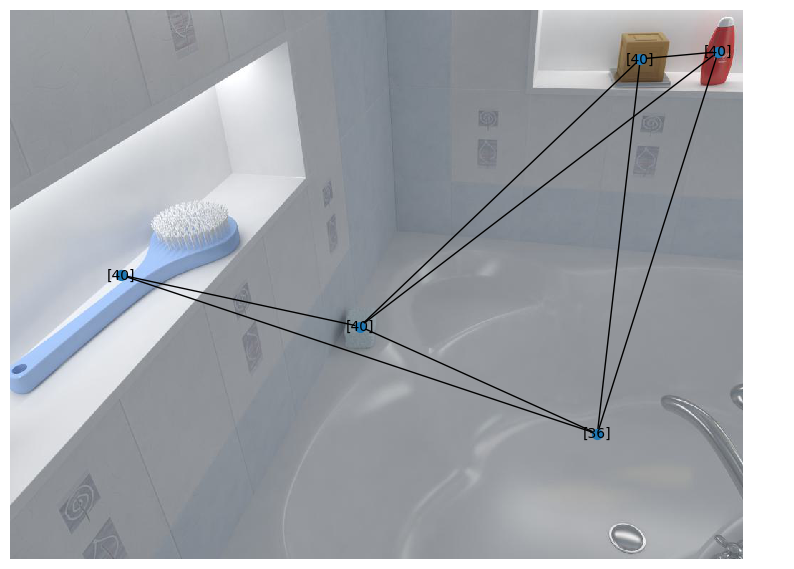

In [35]:
############ ARGS #############
download_dir = r".\contrib\99991\downloads"
scene_name = r"ai_001_001"
camera_name = r"cam_00"
n_frames = 3 # number of frames to process
###############################

scene_dir = os.path.join(download_dir, scene_name)
images_dir = os.path.join(scene_dir, "images") # frame
preview_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_final_preview") # frame
geometry_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_geometry_hdf5") # frame

# Import dataset-, scene- and camera-specific files
nyu_labels, scene_labels = import_dataset_labels()
bb_sizes, bb_rot, bb_pos, mesh_objects_si, mesh_objects_sii, metadata_objects, a2m = import_scene(scene_name, scene_dir)
camera_pos_all, camera_rot_all = import_camera(scene_dir, camera_name)

#### Assign a label to each BB (scene-specific assignment)
n_bb = bb_pos.shape[0] - 1
bb_labels, bb_error = assign_labels(mesh_objects_sii, mesh_objects_si, metadata_objects, nyu_labels, bb_pos)

# Frame-specific files
tonemap_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_final_preview", "frame.*.tonemap.jpg")
segmentation_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_geometry_hdf5", "frame.*.semantic_instance.hdf5")

filenames_tonemap = [ os.path.basename(f) for f in sort(glob.glob(tonemap_files_dir)) ]
filenames_segmentation = [ os.path.basename(f) for f in sort(glob.glob(segmentation_files_dir)) ]

# Calculate Euclidian distance between nodes and compare to threshold value
# Only need to calculate the distance mask once for every scene
threshold = 1.5
distance_mask = calculate_distance(threshold, a2m, bb_pos, bb_error)

# Obtain label graph (used for all scenes)
scene_names = [y[:-7] for y in scene_labels[:,0]]
scene_labels_c = np.c_[scene_names, scene_labels[:,1:]]
scenes = np.unique(scene_labels[:,1])
scene = None
remove = []

for i, row in enumerate(scene_labels_c):
    if row[0] == scene:
        remove.append(i)
    else:
        scene = row[0]

remove = np.array(remove)
scene_labels_c = np.delete(scene_labels_c, remove, axis=0)

scene_ids = np.zeros_like(scene_labels_c[:,0], dtype=int)
# print(scene_ids)
for i, s in enumerate(scenes):
    s_id = np.where(scene_labels_c[:,1] == s)
    scene_ids[s_id] = i

# scene_labels_c = np.concatenate((scene_labels_c, scene_ids[:, np.newaxis]), axis=1, dtype=object)
scene_labels_c = np.concatenate((scene_labels_c, scene_ids[:, np.newaxis]), axis=1)
y = torch.tensor(scene_labels_c[:,3].astype(int))

# Iterate through frames (given scene and camera):
for tonemap_file, segmentation_file, frame_id in zip(filenames_tonemap[:n_frames], filenames_segmentation[:n_frames], arange(n_frames)):
    counter = 0
    tonemap_dir = os.path.join(preview_files_dir, tonemap_file)
    segmentation_dir =  os.path.join(geometry_files_dir, segmentation_file)

    # Load tonemap and segmentation for current frame
    tonemap, segmentation = import_frame(tonemap_dir, segmentation_dir)
    print(frame_id, ": loaded", tonemap_file, "and", segmentation_file)

    # Select BB that are present in current frame
    bb_in_sample = unique(segmentation)
    if bb_in_sample[0] == -1:
        bb_in_sample = bb_in_sample[1:] # discard -1 label (pixels in segmentation map with unidentified BB)
    n_bb_in_sample = bb_in_sample.shape[0]

    # Construct adjacency matrix
    adjacency_matrix = construct_adjacency_matrix(n_bb, bb_in_sample, distance_mask)

    # Transform adjacency matrix to adjacency list in COO format
    row, col = np.where(adjacency_matrix)
    edge_index_np = np.array(list(zip(row, col)))

    nodes_present = unique(edge_index_np) # refers to BB number, indexing starts at 0
    new_idx = []
    for node0, node1 in edge_index_np:
        new_node0 = np.where(node0 == nodes_present)[0][0]
        new_node1 = np.where(node1 == nodes_present)[0][0]
        new_idx.append((new_node0, new_node1))
    edge_index = torch.tensor(np.array(new_idx)).t()
    
    # Transform bb_labels to node features (tensor matrix with shape [num_nodes, num_node_features])
    bb_labels_in_sample = np.array([bb_labels[i-1] for i in bb_in_sample]) # indexing starts at 0
    x = torch.tensor(np.array(bb_labels_in_sample)) # indexing starts at 0

    # Get relevant graph label
    y_scene = y[np.where(scene_name == scene_labels_c[:,0])]

    # Construct Data object
    data = Data(edge_index=edge_index, x=x, y=y_scene)
    print(data)

    # if counter == 0:
    #     hf = h5py.File('data.h5', 'a')
    #     hf.create_dataset('dataset', data=data, compression="gzip", chunks=True, maxshape=(None,))

    # counter += 1    
    
    ############ PLOTTING ############
    # Plot labelled BB as graph on top of tonemap
    # First, calculate frame-specific variables (image size and camera placement for current frame)
    height_pixels = tonemap.shape[0] 
    width_pixels  = tonemap.shape[1]
    camera_pos = camera_pos_all[frame_id]
    camera_rot = camera_rot_all[frame_id]
    # Then, plot
    plot_scene(n_bb, bb_pos, bb_in_sample, camera_pos, camera_rot, height_pixels, width_pixels, adjacency_matrix, bb_labels, tonemap)
    if n_frames > 1:
        plt.show()

In [34]:
# vis = to_networkx(data)
# plt.figure(1,figsize=(8,8)) 
# nx.draw(vis, cmap=plt.get_cmap('Set3'), node_size=70,linewidths=6)
# plt.show()

In [20]:
type(data)

torch_geometric.data.data.Data

In [ ]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    # TODO
    @property
    def raw_file_names(self):
        return 'raw_data.pt'

    # TODO
    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = [...]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [52]:
# TODO: delete scenes with added comment (usually weird or unusual scenes)
print(scene_labels[:30,2]) # preview first 30 items

# TODO: assign graph label based on one of these (number them)
# TODO: delete scenes with OUTSIDE...
scenes = np.unique(scene_labels[:,1])
scenes

['' 'Office (music studio)' 'Office (music studio)'
 'Office (music studio)' 'Office (music studio)' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' 'Hallway (outdoor; weird)'
 'Bathroom (weird)' '' 'Retail space (weird)']


array(['Art gallery', 'Bathroom', 'Bedroom', 'Courtyard', 'Dining room',
       'Hall', 'Hallway', 'Hotel lobby', 'Kitchen', 'Lecture theater',
       'Library', 'Living room',
       'OUTSIDE VIEWING AREA (BAD INITIALIZATION)',
       'OUTSIDE VIEWING AREA (BAD TRAJECTORY)', 'Office',
       'Office (building foyer)', 'Office (conference room)',
       'Office (home)', 'Office (waiting area)', 'Other', 'Restaurant',
       'Retail space', 'Staircase', 'Transit station'], dtype='<U50')